<a href="https://colab.research.google.com/github/torbenbillow/CBS-AML-PROJECT/blob/main/notebooks/00_welcome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, max_error, mean_absolute_percentage_error)

from google.colab import drive
pd.options.mode.copy_on_write = True


# LOAD DATA FROM GOOGLE DRIVE

In [52]:
print("Loading raw data from Gdrive location...")
file_id = "1Iyr7zX8u0gKWKUWCSgZUpcvbTuYBmw1V"
url = f"https://drive.google.com/uc?id={file_id}"

listings_raw = pd.read_csv(url)
print("Raw Data Shape:",listings_raw.shape)

print("Loading feature selection data from Gdrive location...")
file_id = "1TcMwa1S699swnO-CSq3vpzl6fdE0Xzln"
url = f"https://drive.google.com/uc?id={file_id}"

feature_selection = pd.read_excel(url)
print("Feature Selection Shape:",feature_selection.shape)

Loading raw data from Gdrive location...
Raw Data Shape: (22684, 79)
Loading feature selection data from Gdrive location...
Feature Selection Shape: (90, 5)


# DATA WRANGLING

## ADD A CODE SNIPPET HERE TO PRINT AN OVERVIEW OF THE DATA WITH POTENTIAL ISSUES THAT WE FIX BELOW

## FILTER THE DATASET TO REMOVE LISTINGS WITHOUT REVIEWS AND WITH NO OCCUPANCY IN THE LAST YEAR

In [53]:
# Load data as df.
df = listings_raw.copy()

''' Remove listings without reviews in 2025 and no occupancy in the last year. We have chosen to filter "last_review" for listings that have
a review within 6 months of the scrape date and "estimated_occupancy_l365d" for listings that have a non-zero value. We have done this to ensure
we are including only listings that are active, and thereby more informative for our model. '''
df = df.query(
    "last_review >= '2025-01-01' and estimated_occupancy_l365d > 0"
)

In [54]:
# Check sizes of data and filtered data
print("Before filtering:",listings_raw.shape, "\nAfter filtering:",df.shape)

Before filtering: (22684, 79) 
After filtering: (10132, 79)


## MANUALLY DROP UNWANTED COLUMNS (DOMAIN KNOWLEDGE)

In [55]:
# Check size of data frame before drops
print("Before column drops:",df.shape)

# The following columns are irrelevant, and thus, we have chosen to drop them.
df = df.drop(columns=["listing_url","scrape_id","source","host_id","host_url","calendar_last_scraped","first_review","host_neighbourhood"])

# The following columns could impact a listing's "success" (discrimination, etc.), but due to the complexity and the scope of this project,
# we have chosen to drop it.
df = df.drop(columns=["name","picture_url","host_name","host_thumbnail_url","host_picture_url"])

# Dropping the following columns in favor of "calculated_host_listings_count," because that is the direct calculation of how many listings
# a host has at the time of scrape. The metadata also notes that this calculation is "unknown," and thereby less trustworthy.
df = df.drop(columns=["host_listings_count","host_total_listings_count"])

# Dropping in favor of "host_identitity_verified," which is a boolean that indicates whether or not the host is verified.
df = df.drop(columns=["host_verifications"])

# Dropping in favor of "neighborhood_cleansed."
df = df.drop(columns=["neighbourhood"])

# Dropping the following, as they are completely empty attributes.
df = df.drop(columns=["neighbourhood_group_cleansed","calendar_updated","license"])

# Dropping the following columns in favor of "mini_nights" and "maximum_nights."
df = df.drop(columns=["minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights","minimum_nights_avg_ntm","maximum_nights_avg_ntm"])

# Dropping the following columns, because there is no information about they represent.
df = df.drop(columns=["has_availability","availability_eoy"])

''' Dropping the following columns, because we have selected "availability_30" as our target variable. We believe this the most accurate
indicator of a listing's popularity/success, because listings will on average be booked more in the short term than in the long term.
We would be able to attribute the availability to an actual "interest level," rather than a lack of booking simply due to time considerations.
Seasonality should not matter since the scope of our listings is limited to Copenhagen, so theoretically, all listings would be impacted equally
by seasonality. '''
df = df.drop(columns=["availability_60","availability_90","availability_365"])

# Dropping the following columns in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ltm","number_of_reviews_l30d"])

# Dropping in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ly"])

# We have chosen to filter this column for listings that have a nonzero value. We have done this to ensure we are only including listings
# that are active, and thereby more informative for our model. MAKE A NOTE OF SELECTION BIAS.
df = df.drop(columns=["estimated_occupancy_l365d"])

# Irrelevant and would introduce data leakage.
df = df.drop(columns=["estimated_revenue_l365d"])

# We have chosen to filter this column for listings that have a review within 6 months of the scrape date. We have done this to ensure we
# are only including listings that are active, and thereby more informative for our model. MAKE A NOTE OF SELECTION BIAS.
df = df.drop(columns=["last_review"])

# Dropping the following attributes because they will not be available at the time of prediction.
df = df.drop(columns=["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])

# Dropping the following columns in favor of "calculated_host_listings_count" for simplicity.
df = df.drop(columns=["calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"])

# Dropping in favor of "number_of_reviews."
df = df.drop(columns=["reviews_per_month"])

# Check size of data frame after drops
print("After column drops:",df.shape)


Before column drops: (10132, 79)
After column drops: (10132, 31)


## CLEAN UP "price" ATTRIBUTE



In [56]:
# Remove $, commas, and spaces, then convert to numeric
price_clean = (
    df["price"]
    .astype(str)                             # handle existing ints / NA
    .str.replace(r'[\$,]', '', regex=True)   # remove $ and commas
    .str.strip()
)

# Convert to numeric, coercing bad values (like '<NA>') to NaN
price_numeric = pd.to_numeric(price_clean, errors="coerce")

# Store back as nullable integer
df["price"] = price_numeric.astype("Int64")

## VALIDATE PRICE ATTRIBUTE

In [92]:
df["price"].describe()

,price
count,9875.0
mean,1328.292354
std,1039.583332
min,202.0
25%,949.0
50%,1168.0
75%,1435.0
max,63418.0


## CREATE TWO DATAFRAMES WITH DIFFERENT "price" APPROACHES

In [57]:
# Create two new dataframes to split between approaches (dropping missing prices vs. imputing missing prices)
df_price_imputation = df.copy()
df_drop_price = df.copy()

median_price = df["price"].median()
df_price_imputation["price"] = df_price_imputation["price"].fillna(median_price).astype("Int64")
df_drop_price = df_drop_price.dropna(subset=["price"])

print("Shape of df with price imputation:", df_price_imputation.shape)
print("Shape of df with dropped blank prices:", df_drop_price.shape)

Shape of df with price imputation: (10132, 31)
Shape of df with dropped blank prices: (7872, 31)


In [58]:
# Create a dictionary with the two split datasets.
# Instead of rewriting the pipeline for each version, we can loop over the dataset dictionary and train/evaluate all models on all variants cleanly.

datasets = {
    "drop_missing_prices": df_drop_price,
    "impute_price": df_price_imputation
}

## CLEAN UP BOOLEAN COLUMNS

In [59]:
# Some cols have boolean values "f" and "t", we change to 0 or 1
bool_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable"
]

bool_map = {
    "t": 1,
    "f": 0,
    "true": 1,
    "false": 0,
    True: 1,
    False: 0,
}

# Fix boolean values in the datasets
for name, df in datasets.items():
  for col in bool_cols:
      df[col] = (df[col].map(bool_map).astype("Int64"))

# Fill missing superhost values with 0 in the datasets
for name, df in datasets.items():
  df["host_is_superhost"] = df["host_is_superhost"].fillna(0).astype("Int64")

# Print results
for name, df in datasets.items():
  print(f"Cleaned up column information for {name} dataframe...\n")
  for col in bool_cols:
    print(f"{col} unique values:", df[col].unique(),"\n")

Cleaned up column information for drop_missing_prices dataframe...

host_is_superhost unique values: <IntegerArray>
[1, 0]
Length: 2, dtype: Int64 

host_has_profile_pic unique values: <IntegerArray>
[1, <NA>, 0]
Length: 3, dtype: Int64 

host_identity_verified unique values: <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64 

instant_bookable unique values: <IntegerArray>
[0, 1]
Length: 2, dtype: Int64 

Cleaned up column information for impute_price dataframe...

host_is_superhost unique values: <IntegerArray>
[1, 0]
Length: 2, dtype: Int64 

host_has_profile_pic unique values: <IntegerArray>
[1, <NA>, 0]
Length: 3, dtype: Int64 

host_identity_verified unique values: <IntegerArray>
[1, 0, <NA>]
Length: 3, dtype: Int64 

instant_bookable unique values: <IntegerArray>
[0, 1]
Length: 2, dtype: Int64 



In [60]:
# We can see based on the information below, that a number of listings have a missing verification status and profile picture.
for name, df in datasets.items():
  print(f"{name} results:")
  print(df[["host_has_profile_pic","host_identity_verified"]].isna().sum(),"\n")

drop_missing_prices results:
host_has_profile_pic      236
host_identity_verified    236
dtype: int64 

impute_price results:
host_has_profile_pic      257
host_identity_verified    257
dtype: int64 



In [61]:
# Given the relatively small number of null rows, we have chosen to drop them rather than impute values.

subset_cols = ["host_has_profile_pic", "host_identity_verified"]

for name, df in datasets.items():
    # Drop rows with NA in any of the subset columns
    df.dropna(subset=subset_cols, inplace=True)

    # Show remaining NA counts for those columns
    print(f"{name} results:")
    print(df[subset_cols].isna().sum(),"\n")

drop_missing_prices results:
host_has_profile_pic      0
host_identity_verified    0
dtype: int64 

impute_price results:
host_has_profile_pic      0
host_identity_verified    0
dtype: int64 



## CLEAN UP MISSING "bed" AND "bedroom" ATTRIBUTES

In [62]:
''' There are three measures for how many people a property fits:
1. "accommodates" = max number of guests
2. "bedrooms" = number of bedrooms
3. "beds" = number of beds '''

for name, df in datasets.items():
  print(f"{name} results:\n",df[['accommodates','bedrooms','beds']].isna().sum(),"\n")

# "accommodates" has no missingness, while the others do, so we use combinations of them to impute values
# We will use all for the training

# THIS RESULT COULD INDICATE A PATTERN OF MISSINGNESS, SINCE ROWS WITH MISSING PRICES ALSO HAVE OTHER MISSING ATTRIBUTES.
# WE COULD CHECK IF THERE IS MISSINGNESS ACROSS, FOR EXAMPLE, A CERTAIN TYPE OF LISTING, THEN THE RESULTS WILL BE SKEWED.

drop_missing_prices results:
 accommodates    0
bedrooms        1
beds            1
dtype: int64 

impute_price results:
 accommodates       0
bedrooms         158
beds            2240
dtype: int64 



In [63]:
# WE ARE DOING THE FOLLOWING ONLY ON THE PRICE IMPUTATION DF, SINCE THE DROP PRICE DF HAS ONLY 1 NULL VALUE.
# Only use rows where all three variables are valid (non-missing, non-zero)
valid = df_price_imputation[
    (df_price_imputation['accommodates'] > 0) &
    (df_price_imputation['beds'] > 0) &
    (df_price_imputation['bedrooms'] > 0)
]

# Compute ratios
valid['guests_per_bed'] = valid['accommodates'] / valid['beds']
valid['beds_per_bedroom'] = valid['beds'] / valid['bedrooms']
valid['guests_per_bedroom'] = valid['accommodates'] / valid['bedrooms']

# Get averages and medians
summary = valid[['guests_per_bed', 'beds_per_bedroom', 'guests_per_bedroom']].agg(['mean', 'median'])
print("Statistics before imputation:\n", summary)

# Use medians for integers
guests_per_bed = summary.loc['median', 'guests_per_bed']
beds_per_bedroom = summary.loc['median', 'beds_per_bedroom']
guests_per_bedroom = summary.loc['median', 'guests_per_bedroom']

# Impute median values where missing
# For missing beds but nonmissing bedrooms, impute median beds per bedroom
df_price_imputation.loc[df_price_imputation['beds'].isna() & df_price_imputation['bedrooms'].notna(), 'beds'] = df_price_imputation['bedrooms'] * beds_per_bedroom

# For remaining missing beds, divide max guest count by median guests per bed
df_price_imputation.loc[df_price_imputation['beds'].isna(), 'beds'] = df_price_imputation['accommodates'] / guests_per_bed

# For missing bedrooms but nonmissing bedrooms, divide beds by beds per bedroom
df_price_imputation.loc[df_price_imputation['bedrooms'].isna() & df_price_imputation['beds'].notna(), 'bedrooms'] = df_price_imputation['beds'] / beds_per_bedroom

# For remaining missing bedrooms, divide max guest count by median guests per bedroom
df_price_imputation.loc[df_price_imputation['bedrooms'].isna(), 'bedrooms'] = df_price_imputation['accommodates'] / guests_per_bedroom

# Re-check missingness
print("\nRE-CHECKING MISSINGNESS ON PRICE IMPUTATION DATAFRAME:\n", df_price_imputation[['accommodates','bedrooms','beds']].isna().sum())

# DROP THE 1 MISSING VALUE FOR THE DROP PRICE DATAFRAME
df_drop_price = df_drop_price.dropna(subset=["beds"])
df_drop_price = df_drop_price.dropna(subset=["bedrooms"])

# Show the results
print("\nRE-CHECKING MISSINGNESS ON DROP PRICE DATAFRAME:\n", df_drop_price[['accommodates','bedrooms','beds']].isna().sum())



Statistics before imputation:
         guests_per_bed  beds_per_bedroom  guests_per_bedroom
mean          1.983956          1.225566            2.261351
median        2.000000          1.000000            2.000000

RE-CHECKING MISSINGNESS ON PRICE IMPUTATION DATAFRAME:
 accommodates    0
bedrooms        0
beds            0
dtype: int64

RE-CHECKING MISSINGNESS ON DROP PRICE DATAFRAME:
 accommodates    0
bedrooms        0
beds            0
dtype: int64


## CLEAN UP MISSING "bathroom" AND "bathroom_text" ATTRIBUTES

In [64]:
# Some properties are missing a number of bathrooms in the "bathrooms" attribute. Instead, it's stored as a string in the "bathrooms_text" attribute.

# AGAIN, THIS RESULT COULD INDICATE A PATTERN OF MISSINGNESS, SINCE ROWS WITH MISSING PRICES ALSO HAVE OTHER MISSING ATTRIBUTES.
# WE COULD CHECK IF THERE IS MISSINGNESS ACROSS, FOR EXAMPLE, A CERTAIN TYPE OF LISTING, THEN THE RESULTS WILL BE SKEWED.

for name, df in datasets.items():
  print(f"CHECKING NULL COUNTS ON {name} DATAFRAME:\n", df[["bathrooms", "bathrooms_text"]].isna().sum().to_frame(name="Null Count"))
  print(f"\nCHECKING MISSINGNESS ON {name} DATAFRAME:\n", df.loc[df["bathrooms"].isna(),["bathrooms","bathrooms_text"]].head(10),"\n")

CHECKING NULL COUNTS ON drop_missing_prices DATAFRAME:
                 Null Count
bathrooms                2
bathrooms_text           2

CHECKING MISSINGNESS ON drop_missing_prices DATAFRAME:
        bathrooms bathrooms_text
106          NaN            NaN
19459        NaN            NaN 

CHECKING NULL COUNTS ON impute_price DATAFRAME:
                 Null Count
bathrooms             2241
bathrooms_text           2

CHECKING MISSINGNESS ON impute_price DATAFRAME:
      bathrooms bathrooms_text
7          NaN      1.5 baths
8          NaN  1 shared bath
9          NaN      1.5 baths
38         NaN         1 bath
44         NaN         1 bath
54         NaN         1 bath
61         NaN         1 bath
83         NaN         1 bath
98         NaN         1 bath
106        NaN            NaN 



In [65]:
# WE ARE DOING THE FOLLOWING ONLY ON THE PRICE IMPUTATION DF, SINCE THE DROP PRICE DF HAS ONLY 2 NULL VALUES.
# Extract the numeric part from bathrooms_text
bathrooms_from_text = (
    df_price_imputation["bathrooms_text"]
    .astype(str)
    .str.extract(r'(\d+(\.\d+)?)')[0]   # capture integers or decimals
    .astype(float)
)

# Fill missing values in bathrooms with extracted numbers
df_price_imputation["bathrooms"] = df_price_imputation["bathrooms"].fillna(bathrooms_from_text)

In [66]:
df_price_imputation["bathrooms"].isna().sum()

np.int64(21)

In [67]:
# WE ARE DOING THE FOLLOWING ONLY ON THE PRICE IMPUTATION DF, SINCE THE DROP PRICE DF HAS ONLY 2 NULL VALUES.
# Drop rest of missing values since the row count is so low

df_price_imputation = df_price_imputation.dropna(subset=['bathrooms'])

In [68]:
df_price_imputation["bathrooms"].isna().sum()

np.int64(0)

In [69]:
# Show the pre results
print("\nCHECKING NULL COUNTS ON PRICE DROP DATAFRAME BEFORE:\n", df_drop_price[["bathrooms", "bathrooms_text"]].isna().sum().to_frame(name="Null Count"))

# DROP THE 2 MISSING VALUES FOR THE DROP PRICE DATAFRAME
df_drop_price = df_drop_price.dropna(subset=["bathrooms"])
df_drop_price = df_drop_price.dropna(subset=["bathrooms_text"])

# Show the post results
print("\nCHECKING NULL COUNTS ON PRICE DROP DATAFRAME AFTER:\n", df_drop_price[["bathrooms", "bathrooms_text"]].isna().sum().to_frame(name="Null Count"))


CHECKING NULL COUNTS ON PRICE DROP DATAFRAME BEFORE:
                 Null Count
bathrooms                2
bathrooms_text           2

CHECKING NULL COUNTS ON PRICE DROP DATAFRAME AFTER:
                 Null Count
bathrooms                0
bathrooms_text           0


## TRANSFORM "description" ATTRIBUTE BY ADDING "description_missing" AND "description_length" ATTRIBUTES

In [70]:
# Description has some missing values
for name, df in datasets.items():
  print(f"CHECK MISSING DESCRIPTION VALUE COUNT FOR {name} DATAFRAME:\n", df["description"].isna().sum(),"\n")

CHECK MISSING DESCRIPTION VALUE COUNT FOR drop_missing_prices DATAFRAME:
 134 

CHECK MISSING DESCRIPTION VALUE COUNT FOR impute_price DATAFRAME:
 176 



In [71]:
for name, df in datasets.items():
  df['description_missing'] = df['description'].isna().astype(int) # Make flag for missing description
  df['description_length'] = df['description'].fillna('').str.len() # Add description length

# Show the results of adding the above columns
for name, df in datasets.items():
  print(f"\ndescription_missing HEAD FOR {name} DATAFRAME:\n", df['description_missing'].head(10))
  print(f"\ndescription_length HEAD FOR {name} DATAFRAME:\n", df['description_length'].head(10))

# We are now dropping the "description" attribute, as we no longer need it (we are not doing any text analysis).
for name, df in datasets.items():
  df = df.drop(columns=["description"])


description_missing HEAD FOR drop_missing_prices DATAFRAME:
 2     0
4     0
5     0
10    0
14    0
16    0
17    0
18    0
21    1
22    1
Name: description_missing, dtype: int64

description_length HEAD FOR drop_missing_prices DATAFRAME:
 2     482
4     412
5      75
10     54
14    170
16    290
17    230
18    352
21      0
22      0
Name: description_length, dtype: int64

description_missing HEAD FOR impute_price DATAFRAME:
 2     0
4     0
5     0
7     0
8     0
9     0
10    0
14    0
16    0
17    0
Name: description_missing, dtype: int64

description_length HEAD FOR impute_price DATAFRAME:
 2     482
4     412
5      75
7     558
8     515
9     471
10     54
14    170
16    290
17    230
Name: description_length, dtype: int64


## TRANSFORM "host_since" ATTRIBUTE BY ADDING "host_tenure_days" ATTRIBUTE

In [72]:
# Data has a host_since feature, so we use it to create a "host_tenure_days" column for each dataframe.

for name, df in datasets.items():
  df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
  latest_scrape = pd.to_datetime(df['last_scraped']).max() # Isolate the latest scrape date for calculation
  df['host_tenure_days'] = (latest_scrape - df['host_since']).dt.days # Create new "host_tenure_days" attribute

In [73]:
for name, df in datasets.items():
  print(f"{name} results: ",df["host_tenure_days"].isna().sum())
  print(f"{name} results: ",df["host_since"].isna().sum())

drop_missing_prices results:  0
drop_missing_prices results:  0
impute_price results:  0
impute_price results:  0


## TRANSFORM "host_about" ATTRIBUTE BY ADDING "host_about_missing" AND "host_about_length" ATTRIBUTES

In [74]:
for name, df in datasets.items():
  df['host_about_missing'] = df['host_about'].isna().astype(int) # Make flag for host about
  df['host_about_length'] = df['host_about'].fillna('').str.len() # Host about length

# We are now dropping the "host_about" attribute, as we are not doing any text analysis
for name, df in datasets.items():
  df = df.drop(columns=["host_about"])

## TRANSFORM "host_response_rate" AND "host_acceptance_rate" BY ADDING "...missing" ATTRIBUTES

In [75]:
# Format as float, add missing flag, fill with median

for name, df in datasets.items():
  for col in ["host_response_rate", "host_acceptance_rate"]:
      temp = df[col].astype(str).str.strip().str.rstrip('%').replace('', np.nan)
      df[col] = pd.to_numeric(temp, errors='coerce')
      df[f"{col}_missing"] = df[col].isna().astype(int)
      df[col] = df[col].fillna(df[col].median())

## TRANSFORM "host_response_time" ATTRIBUTE BY ADDING CATEGORY FOR MISSING VALUES CALLED "unknown"

In [76]:
# Response time is a category
# Fill unknown or missing response time with category "unknown"

for name, df in datasets.items():
  df['host_response_time'] = df['host_response_time'].fillna('unknown')

## TRANSFORM "neighborhood_overview" ATTRIBUTE BY ADDING "neighborhood_overview_length" AND "neighborhood_overview_missing" ATTRIBUTES

In [77]:
for name, df in datasets.items():
  df['neighborhood_overview_missing'] = df['neighborhood_overview'].isna().astype(int) # Make flag for neighboorhood overview
  df['neighborhood_overview_length'] = df['neighborhood_overview'].fillna('').str.len() # Neighborhood overview length

# We are now dropping the "neighborhood_overview" attribute, as we are not doing any text analysis
for name, df in datasets.items():
  df = df.drop(columns=["neighborhood_overview"])

# Print results
for name, df in datasets.items():
  print(f"{name} results: ",df[["neighborhood_overview_missing","neighborhood_overview_length"]].isna().sum())

drop_missing_prices results:  neighborhood_overview_missing    0
neighborhood_overview_length     0
dtype: int64
impute_price results:  neighborhood_overview_missing    0
neighborhood_overview_length     0
dtype: int64


## TRANSFORM "host_location" ATTRIBUTE BY ADDING "host_location_missing" ATTRIBUTE

In [78]:
for name, df in datasets.items():
  df['host_location_missing'] = df['host_location'].isna().astype(int) # Make flag for host location

# We are now dropping the "host_location" attribute, as we are not doing any text analysis
for name, df in datasets.items():
  df = df.drop(columns=["host_location"])

# Print results
for name, df in datasets.items():
  print(f"{name} results: ",df[["host_location_missing"]].isna().sum())

drop_missing_prices results:  host_location_missing    0
dtype: int64
impute_price results:  host_location_missing    0
dtype: int64


In [90]:
df_drop_price.sort_values(by="price", ascending=True).head(10)

,id,last_scraped,description,neighborhood_overview,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,number_of_reviews,instant_bookable,calculated_host_listings_count
18889,1238262978213679080,2025-06-29,Book a bed (or more) in our shared 8-Bed Dorm ...,NaN,2019-06-24,Denmark,NaN,within an hour,100%,100%,...,1.0,2.0,"[""Backyard"", ""Hot water"", ""Hangers"", ""Carbon m...",202,1,365,27,47,1,22
5990,38542262,2025-07-02,Come join us at our indoor urban campsite! Urb...,Urban Camper is located 150 meters from the ne...,2019-09-11,"Copenhagen, Denmark",NaN,within an hour,97%,100%,...,1.0,4.0,"[""Wifi"", ""Luggage dropoff allowed"", ""Dedicated...",210,1,365,30,1337,1,1
18899,1238308968105997429,2025-07-01,Sharing is caring – get ready to make some fri...,NaN,2019-06-24,Denmark,NaN,within an hour,100%,100%,...,1.0,1.0,"[""Wifi"", ""Hair dryer"", ""Hangers"", ""Backyard"", ...",222,1,365,27,17,1,22
18963,1242560997046965118,2025-07-02,Book a bed (or more) in our shared 8-Bed Dorm ...,NaN,2019-06-24,Denmark,NaN,within an hour,100%,100%,...,1.0,2.0,"[""Carbon monoxide alarm"", ""Heating"", ""Hair dry...",224,1,365,30,23,1,22
8473,558662195416544669,2025-06-27,Newly renovated private room for rent in a 3-r...,The property is located in a safe and quiet ne...,2022-02-09,"Copenhagen, Denmark",As a person I am very relaxed. I love to meet ...,within a day,93%,68%,...,1.0,1.0,"[""Freezer"", ""Dedicated workspace"", ""Hot water""...",230,31,365,0,9,0,9
20256,1344301400666328064,2025-06-27,Lovely bright and stylish private room with ac...,NaN,2022-02-09,"Copenhagen, Denmark",As a person I am very relaxed. I love to meet ...,within a day,93%,68%,...,1.0,1.0,"[""Freezer"", ""Dedicated workspace"", ""Hot water""...",230,31,365,0,1,0,9
20241,1343590097277940458,2025-06-30,NaN,NaN,2019-05-23,"Copenhagen, Denmark",Copenhagen Downtown Hostel is famous for its e...,within an hour,84%,98%,...,1.0,1.0,"[""Luggage dropoff allowed"", ""Hair dryer"", ""Fir...",231,1,365,27,9,1,10
5157,33873577,2025-06-27,Brand new built apartment with directly access...,"The apartment is close to “Søndermarken”, Fred...",2013-11-15,"Copenhagen, Denmark",I live in Copenhagen with my two kids. I am a ...,within an hour,100%,100%,...,1.0,1.0,"[""Essentials"", ""Hot water"", ""Iron"", ""Lock on b...",232,1,1125,1,53,1,7
14083,947833366984318016,2025-06-30,Lovely bright private room with access to sunn...,NaN,2022-02-09,"Copenhagen, Denmark",As a person I am very relaxed. I love to meet ...,within a day,93%,68%,...,1.0,1.0,"[""Dedicated workspace"", ""Essentials"", ""Fire ex...",235,31,365,20,3,0,9
15684,1083311120531877866,2025-06-27,"Charming basement room with private entrance, ...",NaN,2015-04-20,"Copenhagen, Denmark",I am relaxed as a person and will do my absolu...,within a day,90%,59%,...,1.0,1.0,"[""Freezer"", ""Hot water"", ""Iron"", ""Room-darkeni...",240,31,365,24,8,0,4


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['latitude'].plot(kind='hist', bins=20, title='latitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['longitude'].plot(kind='hist', bins=20, title='longitude')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['accommodates'].plot(kind='hist', bins=20, title='accommodates')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('last_scraped').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('neighborhood_overview').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('host_since').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('host_location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='id', y='latitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='latitude', y='longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='longitude', y='accommodates', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='accommodates', y='bathrooms', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['host_response_time']
  ys = series['id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('host_response_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('last_scraped')):
  _plot_series(series, series_name, i)
  fig.legend(title='last_scraped', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('host_response_time')
_ = plt.ylabel('id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['host_response_time']
  ys = series['id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('host_response_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('neighborhood_overview')):
  _plot_series(series, series_name, i)
  fig.legend(title='neighborhood_overview', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('host_response_time')
_ = plt.ylabel('id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['host_response_time']
  ys = series['id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('host_response_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('host_since')):
  _plot_series(series, series_name, i)
  fig.legend(title='host_since', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('host_response_time')
_ = plt.ylabel('id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['host_response_time']
  ys = series['id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('host_response_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('host_location')):
  _plot_series(series, series_name, i)
  fig.legend(title='host_location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('host_response_time')
_ = plt.ylabel('id')

from matplotlib import pyplot as plt
_df_16['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['latitude'].plot(kind='line', figsize=(8, 4), title='latitude')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['longitude'].plot(kind='line', figsize=(8, 4), title='longitude')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['accommodates'].plot(kind='line', figsize=(8, 4), title='accommodates')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['neighborhood_overview'].value_counts()
    for x_label, grp in _df_20.groupby('last_scraped')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('last_scraped')
_ = plt.ylabel('neighborhood_overview')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['host_since'].value_counts()
    for x_label, grp in _df_21.groupby('neighborhood_overview')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('neighborhood_overview')
_ = plt.ylabel('host_since')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['host_location'].value_counts()
    for x_label, grp in _df_22.groupby('host_since')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('host_since')
_ = plt.ylabel('host_location')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['host_about'].value_counts()
    for x_label, grp in _df_23.groupby('host_location')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('host_location')
_ = plt.ylabel('host_about')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['last_scraped'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='id', y='last_scraped', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['neighborhood_overview'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='id', y='neighborhood_overview', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['host_since'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='id', y='host_since', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['host_location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='id', y='host_location', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## CREATE HEX BINS FROM LONG/LAT TO ADD A MORE GRANULAR LOCATION ATTRIBUTE

In [79]:
# Neighborhood data is not very granular
# Long and lat used to create hexbins

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# --- 1. Create GeoDataFrame from lat / lon ---

gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# Project to a metric CRS (UTM zone – here: 32N, good for Denmark/southern Sweden)
gdf = gdf.to_crs(epsg=32632)


# --- 2. Helper: build a single regular hexagon around a center ---

def make_hexagon(cx, cy, radius):
    """
    Create a pointy-top regular hexagon centered at (cx, cy)
    with given radius (distance from center to each vertex).
    """
    # Pointy-top: start at 30° and step by 60°
    angles = np.deg2rad(np.arange(0, 360, 60) + 30)
    coords = [(cx + radius * np.cos(a), cy + radius * np.sin(a)) for a in angles]
    return Polygon(coords)


# --- 3. Build a hex grid over the extent of gdf ---

def make_hex_grid(gdf, radius):
    """
    Create a pointy-top hexagon grid covering the extent of gdf.
    radius = distance from hex center to each vertex (in CRS units, e.g. meters).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds

    # Pointy-top spacing (Red Blob Games):
    # horizontal distance between centers = sqrt(3) * radius
    # vertical distance between rows = 1.5 * radius
    dx = np.sqrt(3) * radius
    dy = 1.5 * radius

    cols = np.arange(xmin - dx, xmax + dx, dx)
    rows = np.arange(ymin - dy, ymax + dy, dy)

    hexes = []
    for row_idx, cy in enumerate(rows):
        for col_idx, cx in enumerate(cols):
            # Offset every second row by half the horizontal spacing
            cx_shifted = cx + (dx / 2.0 if row_idx % 2 == 1 else 0.0)
            hex_poly = make_hexagon(cx_shifted, cy, radius)
            hexes.append(hex_poly)

    hex_grid = gpd.GeoDataFrame(
        {"hex_id": range(len(hexes))},
        geometry=hexes,
        crs=gdf.crs
    )
    return hex_grid


# --- 4. Generate hex grid + optional trimming ---

hex_radius = 250  # meters
hex_grid = make_hex_grid(gdf, hex_radius)

# Optional trimming to a buffered convex hull of listings
study_area = gdf.geometry.union_all().convex_hull.buffer(2 * hex_radius)
hex_grid = hex_grid[hex_grid.intersects(study_area)].reset_index(drop=True)
hex_grid["hex_id"] = hex_grid.index  # reindex after trimming

# --- 5. Spatial join: assign each listing to a hex ---

joined = gpd.sjoin(
    gdf,
    hex_grid[["hex_id", "geometry"]],
    how="left",
    predicate="within"   # use "intersects" if you see edge-cases
)

# Join hex_id to the original df

merged = df.merge(joined[["id", "hex_id"]], on="id")


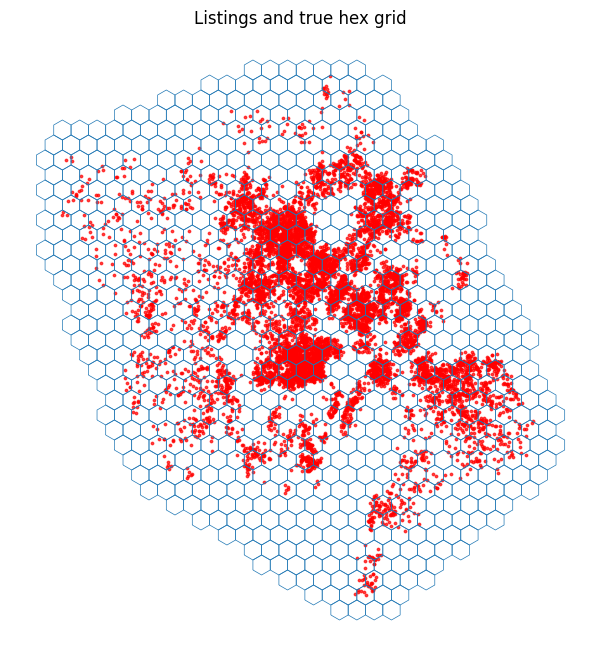

In [80]:
# --- Visualization: check that hexes look like hexes ---

fig, ax = plt.subplots(figsize=(8, 8))

# plot hex outlines
hex_grid.boundary.plot(ax=ax, linewidth=0.5)

# plot listing points
gdf.plot(ax=ax, markersize=3, color="red", alpha=0.7)

ax.set_title("Listings and true hex grid")
ax.set_axis_off()
plt.show()

### Mapping hexes

In [81]:
import folium

# Convert hexes and points to WGS84 (lat/lon)
hex_wgs = hex_grid.to_crs(epsg=4326)
pts_wgs = gdf.to_crs(epsg=4326)

center_lat = pts_wgs.geometry.y.mean()
center_lon = pts_wgs.geometry.x.mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

folium.GeoJson(
    hex_wgs,
    name="Hex grid",
    style_function=lambda feature: {
        "fillColor": "none",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.1,
    },
).add_to(m)

sample_pts = pts_wgs.sample(min(2000, len(pts_wgs)), random_state=0)

for _, row in sample_pts.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

m

# FEATURE SELECTION

In [82]:
# Fetch selected features and filter columns
features = feature_selection.loc[feature_selection['keep_2'] == True, "feature"].tolist()
features = features[0:-1]

In [83]:
df_filtered = df[features]

KeyError: "['host_since_missing'] not in index"

In [ ]:
df_filtered.isna().sum()

In [ ]:
df_filtered.head(10)